In [1]:
import os
import numpy as onp
os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import numpy as np, random as jr, scipy as jsp
from zodiax.experimental import deserialise

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.transforms import Affine2D
import ehtplot
import scienceplots
from geckos_colourmap import geckos_div
import datetime
from tqdm.notebook import tqdm

# astronomy
import webbpsf

# optimisation
import optax

# AMIGO
import amigo
from amigo.core import AMIOptics, SUB80Ramp, BaseModeller
from amigo.fitting import optimise
from amigo.files import get_files, get_exposures, get_filters, initialise_params
from amigo.step_mappers import LocalStepMapper, VisibilityMapper

from io_funcs import initialise_disk, SimpleIoSource, ComplexIoSource, set_all_params, DefinitelyRealIo, get_filter_spectrum, grab_first_value
from optim_funcs import sgd, adam, grad_fn, simple_norm_fn, complex_norm_fn
from optim_funcs import L1_loss, L2_loss, TV_loss, QV_loss, ME_loss, loss_fn
from amigo.modelling import model_fn
from plotting import plot_io_with_truth, plot_params

# files
from zodiax.experimental import deserialise

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)
# jax.config.update("jax_debug_nans", True)

sunset_dark = geckos_div(variation="geckos_sunset_darkred")
sunset = geckos_div(variation="geckos_sunset")

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


# Model Setup

This is a bit rough, I'm loading in the real data files and building the model off that -- will later replace these with simulated data arrays.

In [2]:
model_dir = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/"
filter_dir = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/data/niriss_filters/"

BFE = deserialise(model_dir + "PolyBFE_trained.zdx")
pupil_mask = deserialise(model_dir + "PolyBFE_AMI_mask.zdx")

In [3]:
EXP_TYPE = "NIS_AMI"
FILTERS = ["F480M", "F430M", "F380M"]
# TARGPROP = ["HD-37093", "HD-36805"]
# TARGPROP = ["AB-DOR"]

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    # "/Users/mcha5804/JWST/ERS1373/calgrps/",
    "/Users/mcha5804/JWST/ERS1373/calslope_18/",
    "calslope",
    EXP_TYPE=EXP_TYPE,
    FILTER=FILTERS,
    **kwargs,
)

files = file_fn()

Optics

In [4]:
# setting number of groups and integrations
ngroups = 3
nints = 1

# Get webbpsf optical system for OPD
inst = webbpsf.NIRISS()
# inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
opd = np.array(inst.get_optical_system().planes[0].opd)

# Get dLux optical system
optics = AMIOptics(
    opd=opd,
    pupil_mask=pupil_mask,
    # radial_orders=[0, 1, 2, 3],
    normalise=True,
    )

nsci = 1
sci_files = []
cal_files = []

for file in files:
    if file[0].header["TARGPROP"] == "IO":
        sci_files.append(file)
    elif file[0].header["TARGPROP"] == "PSFCAL.2022A-HD2236-K6":
        cal_files.append(file)
    else:
        print(f"Unkown target: {file[0].header['TARGPROP']}")
sci_file = sci_files[0]

# Overwriting for simulated data
sci_file[0].header["NGROUPS"] = ngroups
sci_file[0].header["NINTS"] = nints

# temporarily turning this into an exposure so can pass to model_fn
# this is only necessary to tell model_fn what ngroups is
temp_exposures = get_exposures([sci_file], optics)
params = initialise_params(temp_exposures)

params["optics"] = optics
# params["aberrations"] = np.zeros(optics.coefficients.shape)

Prepping exposures...


Source

In [5]:
n_ios = 1
eps = 1e-16
roll_angle_degrees = 26.5  # deg
canon_io = DefinitelyRealIo(night_day_ratio=1, volc_frac=0.2, seed=2, n_volcanoes=3)
filt = "F430M"

params["filters"] = get_filters(files)
wavels, weights = params["filters"][filt]

params["fluxes"] = set_all_params(temp_exposures, np.array(7.0))  # fluxes is log10 flux

params["source"] = SimpleIoSource(
    position=jr.uniform(key, (2,), minval=-0.5, maxval=0.5),
    log_flux=jr.uniform(key, (1,), minval=6.9, maxval=7.1),
    log_distribution=np.log10(canon_io.distribution),
    spectrum=get_filter_spectrum(filt, file_path=filter_dir),
)

# params["source"] = ComplexIoSource(
#     position=jr.uniform(key, (2,), minval=-0.5, maxval=0.5),
#     log_flux=jr.uniform(key, (1,), minval=6.9, maxval=7.1),
#     volc_frac=1e-1,
#     log_volcanoes=np.log10(canon_io.volcanoes / canon_io.volcanoes.sum() + eps),
#     # distribution=canon_io.data,
#     spectrum=get_filter_spectrum(filt, file_path="/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/data/niriss_filters/"),
# )

Detector

In [6]:
detector = SUB80Ramp()

params["one_on_fs"] = set_all_params(temp_exposures, 10*jr.normal(key, (ngroups, 80, 2)))
# params["one_on_fs"] = set_all_params(temp_exposures, np.zeros((ngroups, 80, 2)))

params["BFE"] = BFE
# params["BFE"] = PolyBFE(ksize=5, oversample=1, orders=[1, 2])

params["detector"] = detector

Final true model

In [7]:
true_model = BaseModeller(params)

# Simulating Data
Loading in the real data

Generating the fake data by replacing a real data file with simulated data and err arrays

In [8]:
clean_slope = model_fn(true_model, temp_exposures[0])

# defining variance from photon and read noise processes
photon_var = clean_slope / nints
read_noise_var = 100. / nints
var = photon_var + read_noise_var  # variances add
std = np.sqrt(var)

# drawing from a normal distribution to get the data
data = jr.normal(key, shape=var.shape) * std + clean_slope

sci_file["SCI"].data = data
sci_file["SCI_VAR"].data = var

sci_files = [sci_file]

# creating exposures
exposures = get_exposures(sci_files, true_model.optics)

Prepping exposures...


In [9]:
def initialise_model(true_model, exposures, eps=1e-16):
    return true_model.set(
        [
            "positions",
            "fluxes",
            "source.log_distribution",
            # "log_volcanoes",
            # "volc_frac",
            "aberrations",
            "one_on_fs"
        ],
        [
            set_all_params(exposures, grab_first_value(true_model, 'positions') + 0.01*jr.normal(jr.PRNGKey(2), (2,))),
            set_all_params(exposures, np.array(6.8)),
            np.log10(initialise_disk(normalise=True) + eps),
            # 0.2,
            set_all_params(exposures, grab_first_value(true_model, 'aberrations')),
            # true_model.aberrations,
            # set_all_params(exposures, np.zeros_like(grab_first_value(true_model, 'one_on_fs'))),
            set_all_params(exposures, grab_first_value(true_model, 'one_on_fs')),
            # true_model.one_on_fs,
        ],
    )

# Optimisation

Setting things up. Firstly step mappers (takes a min)

In [10]:
# initial model
initial_model = initialise_model(true_model, exposures)

# Calculate local step matrices
local_mappers = []
for exp in exposures:
    local_mappers.append(LocalStepMapper(initial_model, exp))

2024-05-28 14:02:52.183862: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2501, f64[] %constant.37), window={size=1x32x32 stride=1x32x32}, to_apply=%region_2.181

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-05-28 14:02:52.622931: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.444132s
Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2501, f64[] %constant.37), window={size=1x3

Main Time: 106.97
Noise Time: 5.04


Run gradient descent!

In [13]:
initial_model = initialise_model(true_model, exposures)

reg_dict = {
    # "L1": 1.e0,
    # "L2": 1.e0,
    # "TV": 1.e0,
    # "QV": 1.e0,
    "ME": 1.e1,
}

reg_func_dict = {
    "L1": L1_loss,
    "L2": L2_loss,
    "TV": TV_loss,
    "QV": QV_loss,
    "ME": ME_loss,
}

args = {
    "model_fn": model_fn,
    "exposures": exposures,
    "step_mappers": local_mappers,
    # "mask": io_mask,
    "reg_dict": reg_dict,
    "reg_func_dict": reg_func_dict,
    }

config = {
    "positions": sgd(1e-1, 0),
    "fluxes": sgd(3.5e-1, 0),
    "log_distribution": adam(5e-1, 2, (6, 0.3), (30, 0.2), b1=0.7),
    # "volc_frac": adam(5e-2, 5, b1=0.7),
    # "log_volcanoes": adam(5e-1, 2, (6, 0.3), b1=0.7),
    "aberrations": sgd(0*1e-2, 9),
    "one_on_fs": sgd(0*2e-1, 5),
    # "optics.coefficients": opt(1e3, 10),
}

# params = list(config.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    initial_model,
    args,
    loss_fn,
    30, 
    config,
    # norm_fn=complex_norm_fn,
    norm_fn=simple_norm_fn,
    grad_fn=grad_fn,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:07
Initial Loss: 76.89


Loss: 76.89, Change: 0.0:   3%|3         | 1/30 [00:00<?, ?it/s]

Step fn compiling...
Full Time: 0:01:03
Final Loss: 8.43


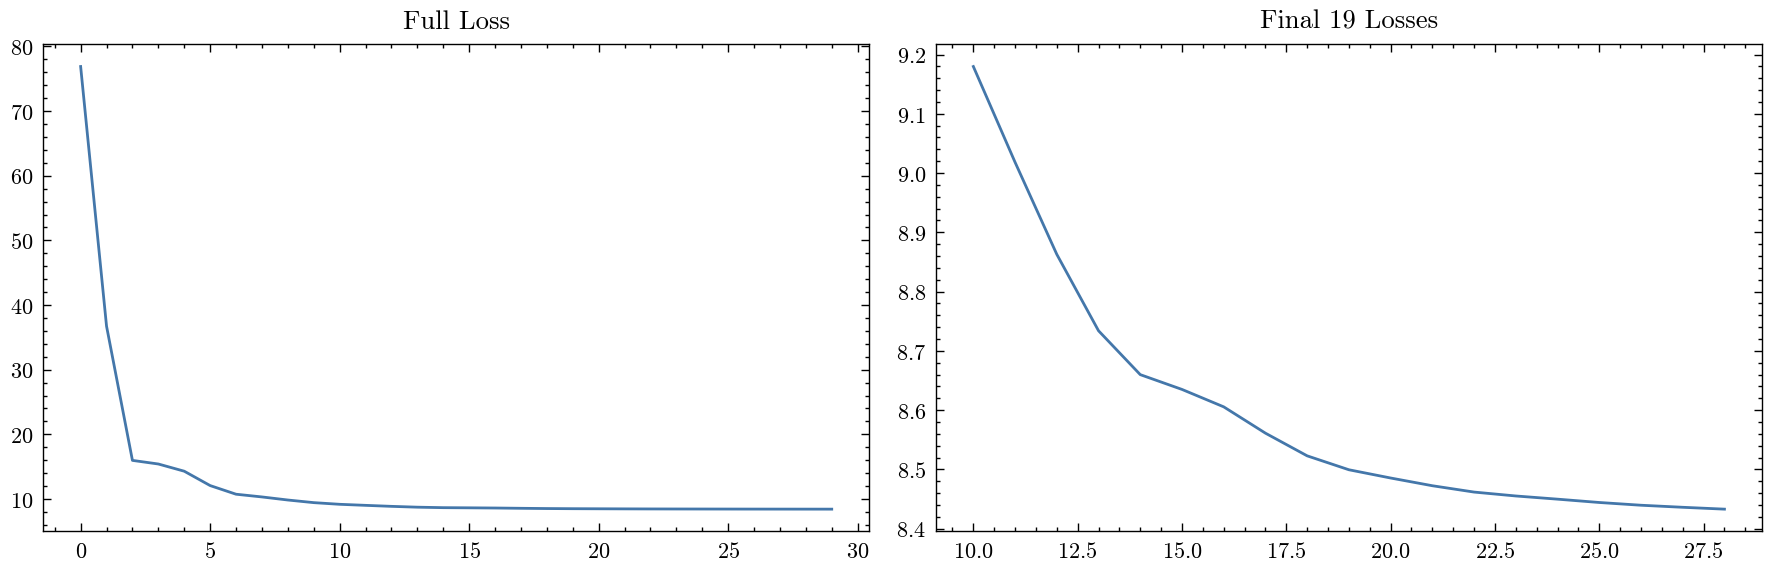

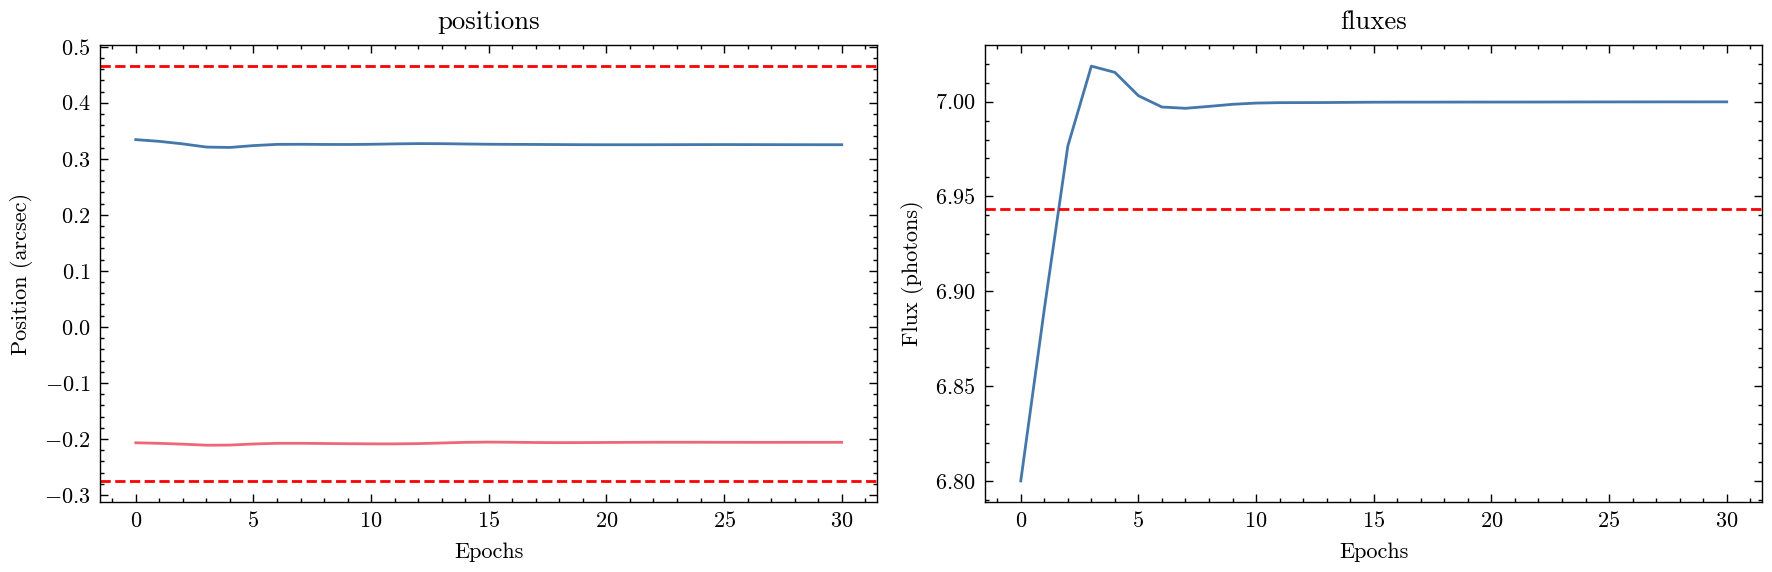

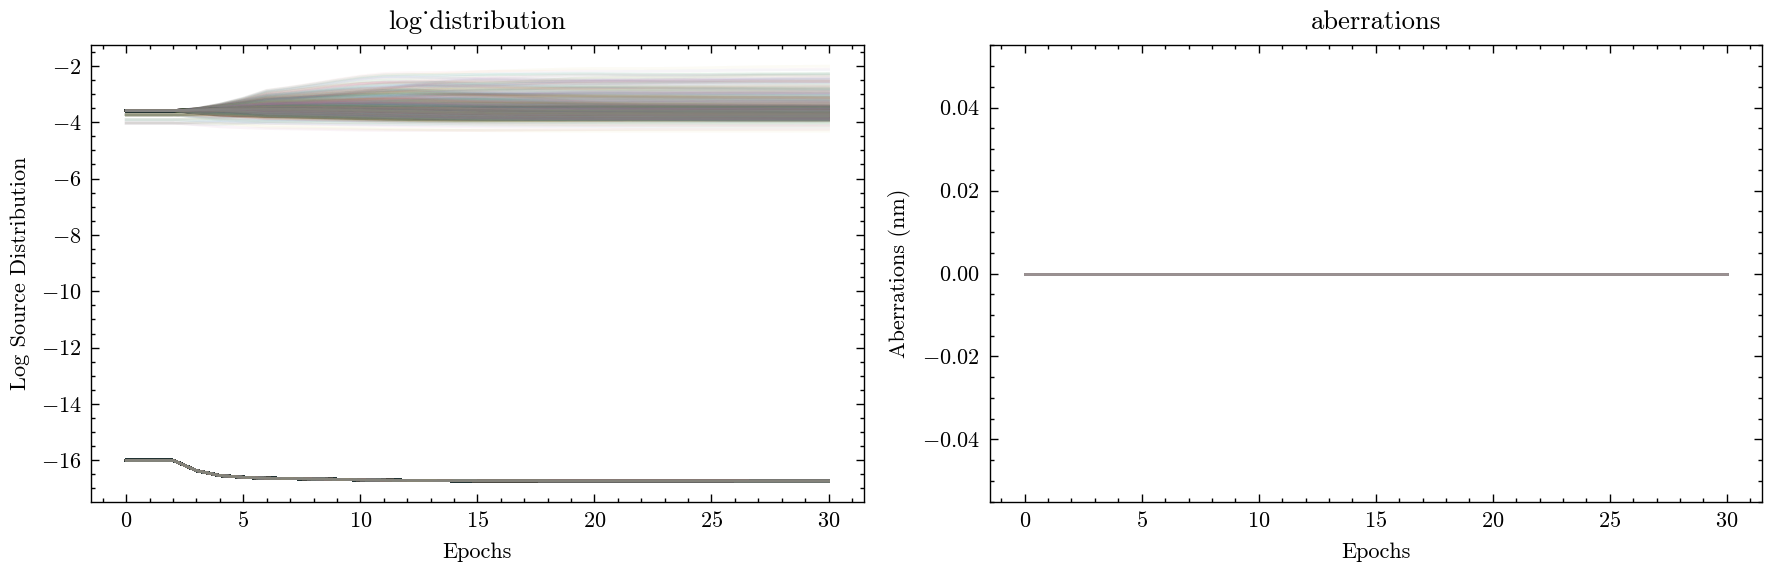

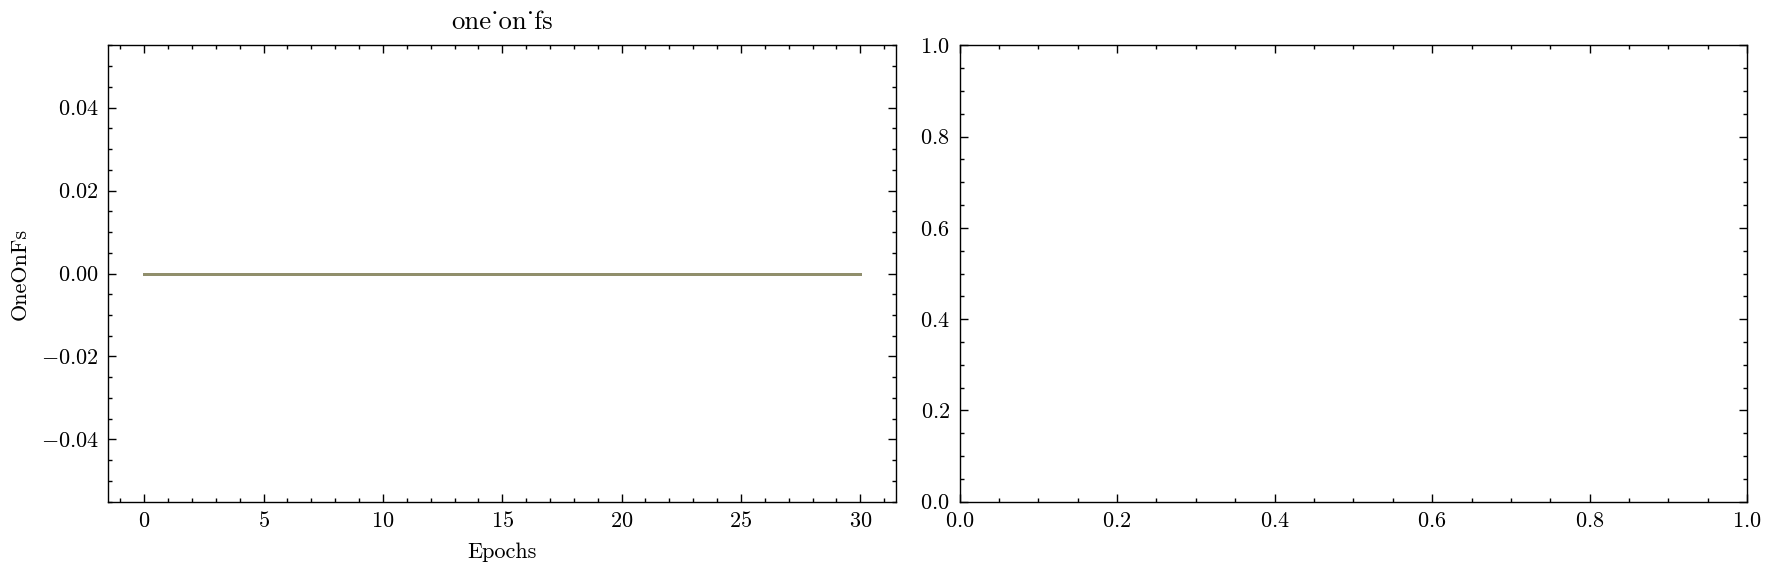

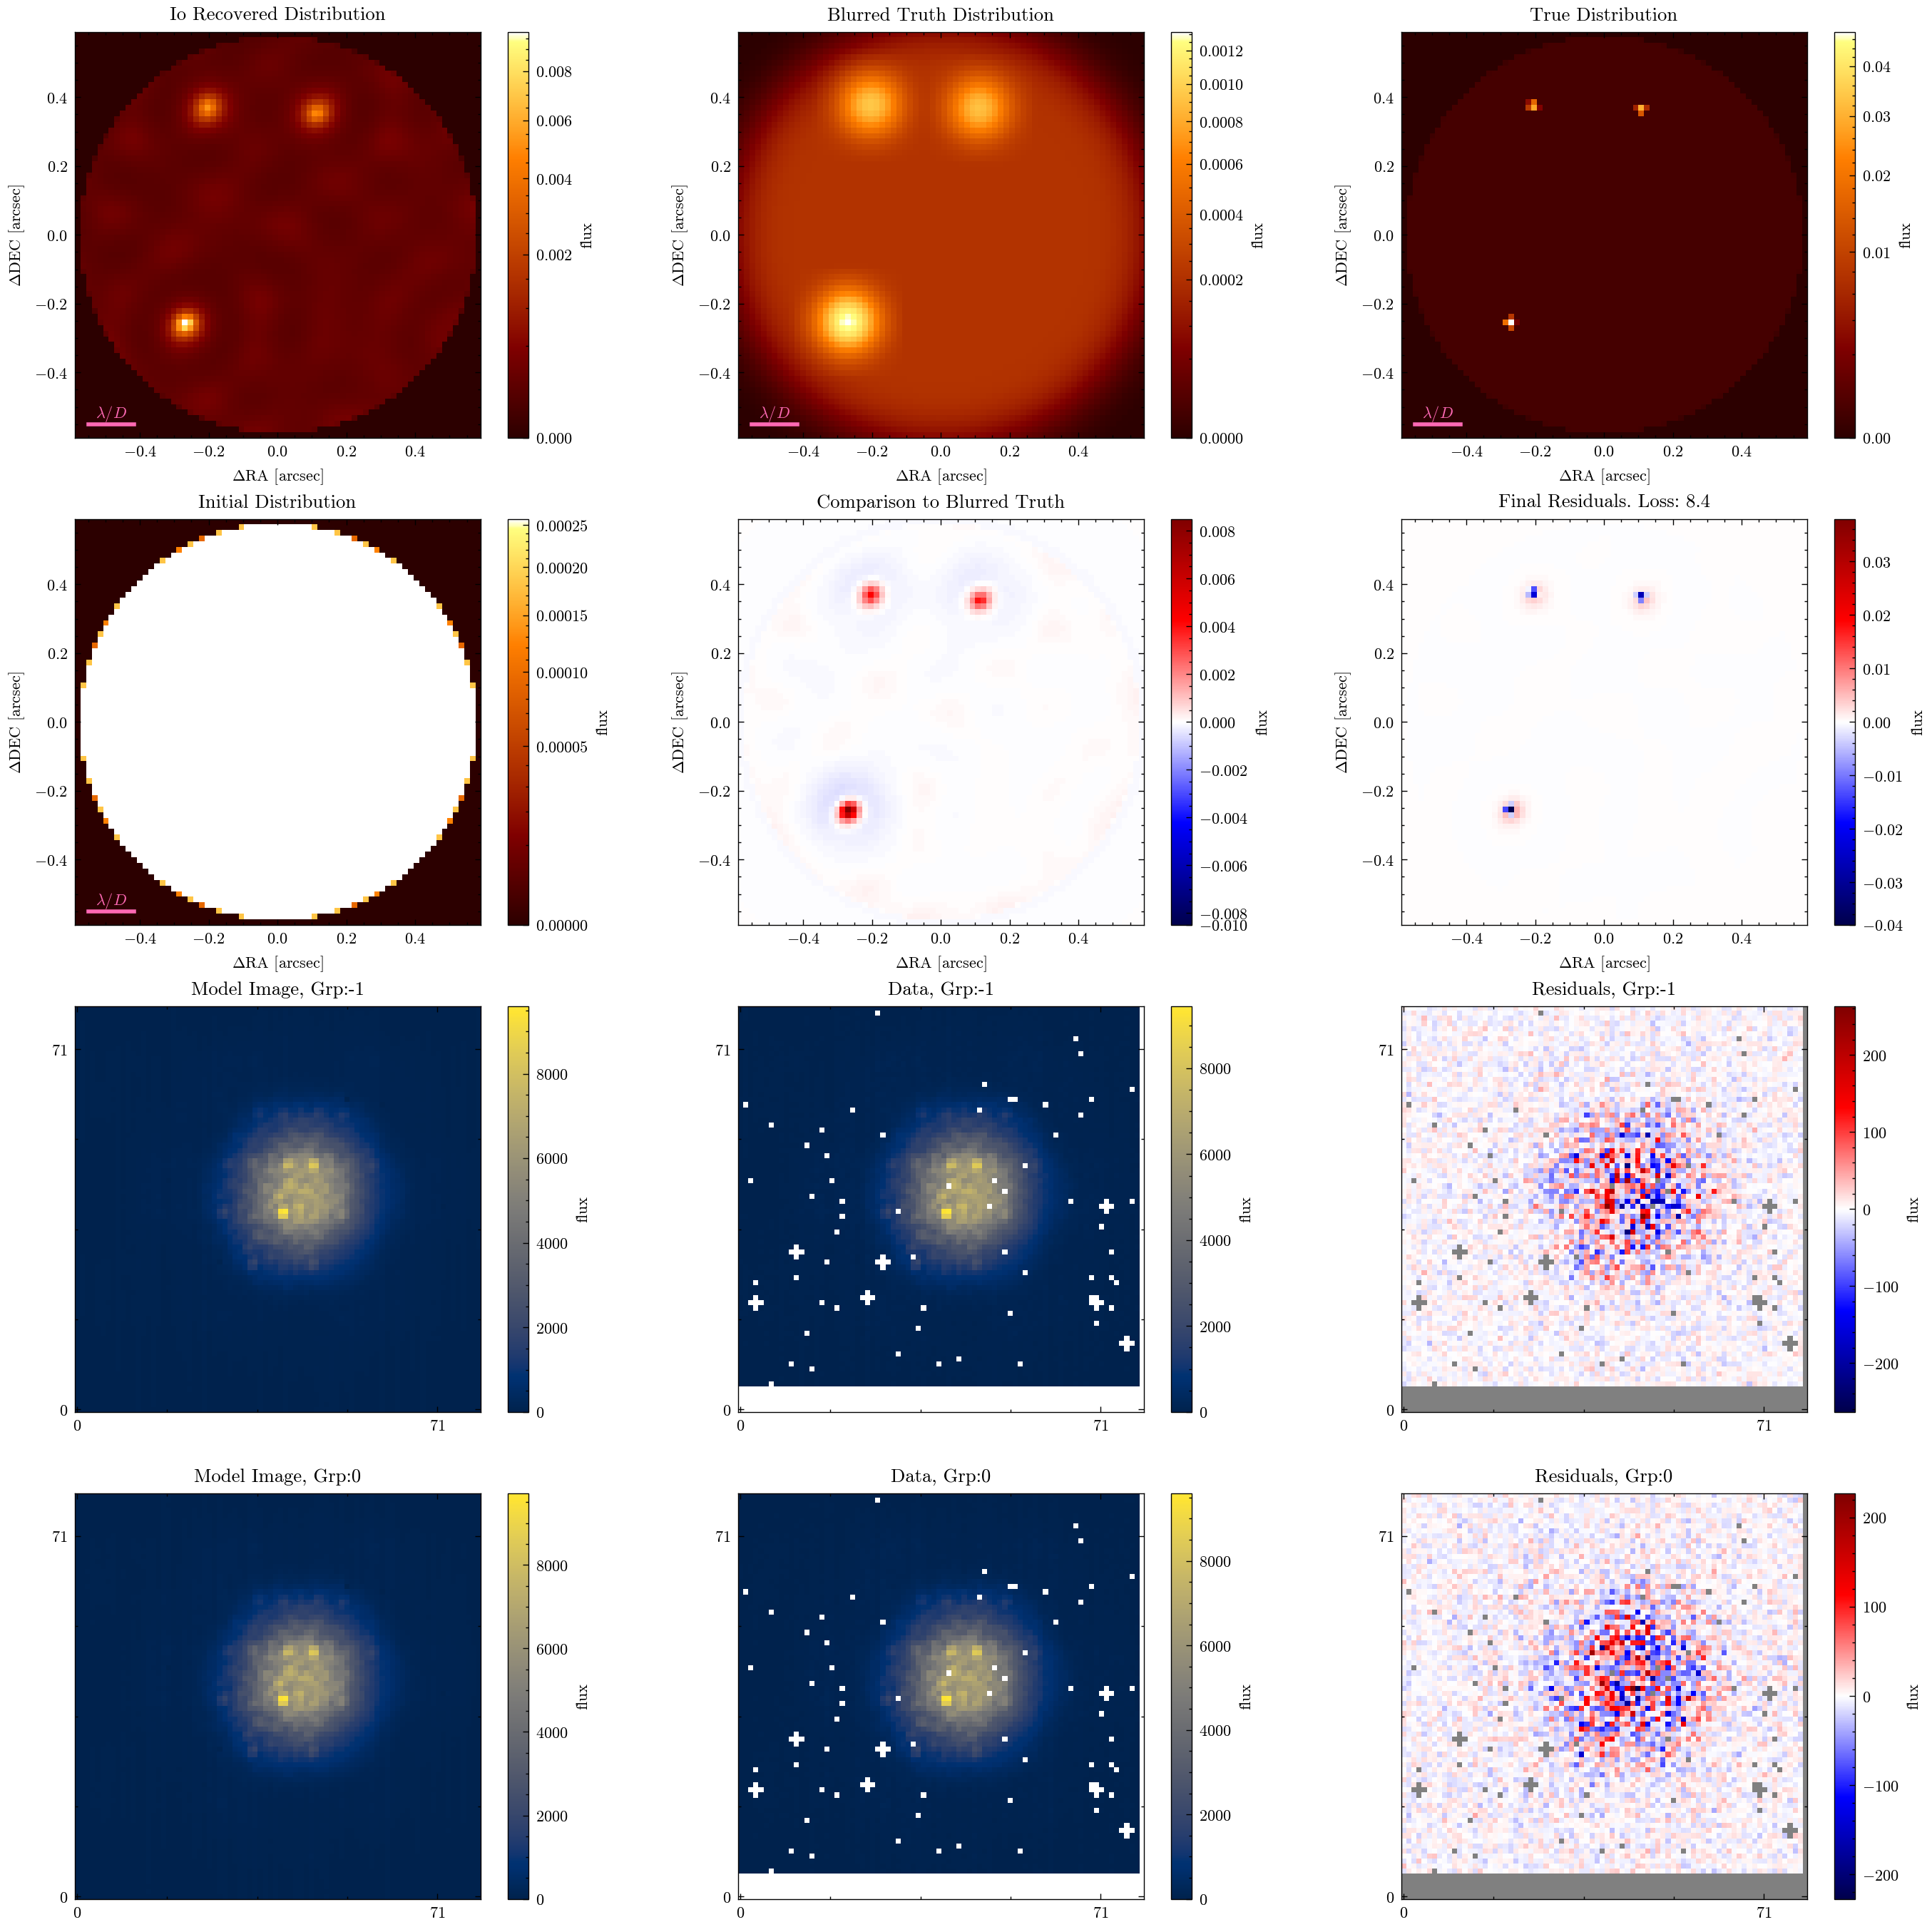

In [14]:
plot_params(np.array(losses), params_out, save=None, true_model=true_model)

# plt.imshow(final_model.distribution, cmap="afmhot_10u")

plot_io_with_truth(
    final_model,
    model_fn,
    exposures,
    losses,
    ngroups,
    opt_state,
    initial_distribution=initial_model.source.distribution,
    # roll_angle_degrees=roll_angle_degrees,
    # cmap="inferno",
    true_model=true_model,
    save=None,
    )
